# Lab6

In [14]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [15]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

Option A: do the calculation with sql

In [16]:
q1_sql = """
SELECT
    year,
    pop,
    ROUND(
        100.0 * (pop - LAG(pop) OVER (ORDER BY year)) / LAG(pop) OVER (ORDER BY year),
        2
    ) AS growth_rate_percent
FROM
    population p
JOIN
    name n ON p.fips = n.fips
WHERE
    n.name = 'California'
ORDER BY
    year;
    """

In [17]:
sql = """
     select * from name_income
     where fips = '06'
     """

In [18]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_8861/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,pop,growth_rate_percent
0,2005,35278768,NaN
1,2006,36457549,3.34
2,2007,36553215,0.26
3,2008,36756666,0.56
4,2009,36961664,0.56


In [19]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [20]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.7 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [23]:
%load_ext jupyter_ai_magics

In [24]:
%%ai gpt4 -f code
What is included in the {q1_df} creates a line chart with the growth rate.
Chart must include the CA name in title

In [ ]:
import matplotlib.pyplot as plt

# Creating DataFrame using the provided data
data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'pop': [35278768, 36457549, 36553215, 36756666, 36961664, 37349363, 37691912, 38041430, 38332521, 38802500, 
            39144818, 39250017, 39536653, 39557045, 39512223],
    'growth_rate_percent': [None, 3.34, 0.26, 0.56, 0.56, 1.05, 0.92, 0.93, 0.77, 1.23, 0.88, 0.27, 0.73, 0.05, -0.11]
}

df = pd.DataFrame(data)

# Plotting data
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['growth_rate_percent'], marker='o')
plt.title('Growth Rate Percent in CA')
plt.xlabel('Year')
plt.ylabel('Growth Rate Percent')
plt.grid(True)
plt.show()

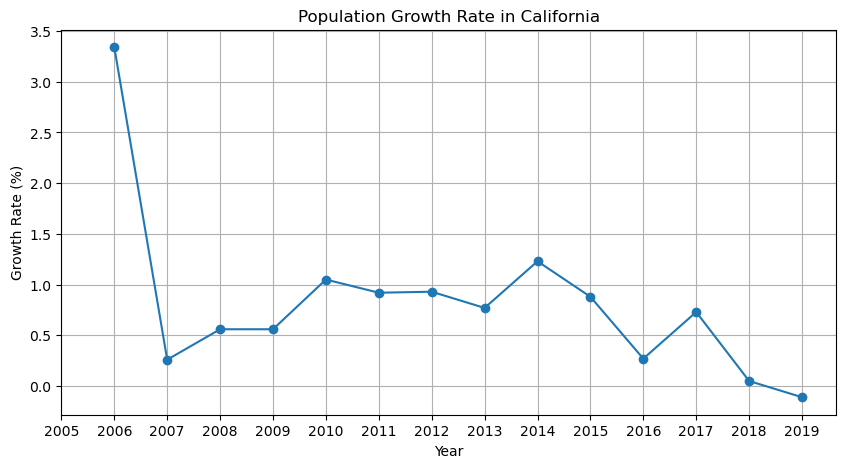

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Recreate the proper DataFrame
df = pd.DataFrame({
    'year': [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    'growth_rate_percent': [None,3.34,0.26,0.56,0.56,1.05,0.92,0.93,0.77,1.23,0.88,0.27,0.73,0.05,-0.11]
})

# Make sure the year column is numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')

plt.figure(figsize=(10,5))
plt.plot(df['year'], df['growth_rate_percent'], marker='o')
plt.title('Population Growth Rate in California')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks(df['year'])   # force the correct x-axis labels
plt.grid(True)
plt.show()


Explanation: This chart shows the growth rate percentage in California from 2005-2019. As seen there is a sharp decrease from 2006 to 2007, then a steady increase to 2010. From there we see mostly a steady decrease to 2013, and then multiple up and down spikes with peaks being at 2014 ande 2017.

## Q2 - Income and Population Relationship

In [26]:
q2_sql = """
SELECT 
    p.year,
    p.pop AS population,
    i.income
FROM income i
JOIN population p 
    ON p.fips = i.fips 
   AND p.year = i.year
WHERE p.fips = '06'
ORDER BY p.year ASC;
"""

In [27]:

q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

/tmp/ipykernel_8861/3723254887.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,year,population,income
0,2005,35278768,53629
1,2006,36457549,56645
2,2007,36553215,59948
3,2008,36756666,61021
4,2009,36961664,58931


In [28]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [32]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [35]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


In [36]:
%%ai gpt4 -f code
use the data in datframe {q2_df},visualization: create a dual-axis chart in python with Jupyter AI's help:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name in the title.

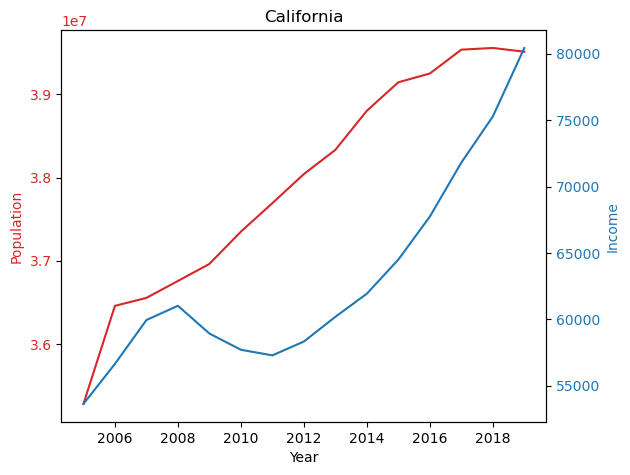

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

df = {'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      'population': [35278768, 36457549, 36553215, 36756666, 36961664, 37349363, 37691912, 38041430, 38332521, 38802500, 
                     39144818, 39250017, 39536653, 39557045, 39512223],
      'income': [53629, 56645, 59948, 61021, 58931, 57708, 57287, 58328, 60190, 61933, 64500, 67739, 71805, 75277, 80440]}

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df['year'], df['population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Income', color=color)  
ax2.plot(df['year'], df['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title("California")
plt.show()

This chart shows the relation of population and income in California from the years 2005-2019. As seen population sees increase for almost the entire time period, while income sees a decrease from 2008-2011 with an increase every other year. 

## Q3 - Median Household Income Growth

In [47]:
# Make  sure pandas is imported
import pandas as pd

# Select only the year and income columns
income_table = df[['year', 'income']].copy()

# Rename columns for readability
income_table.columns = ['Year', 'Median Household Income ($)']

# Format the income values with commas and dollar signs
income_table['Median Household Income ($)'] = income_table['Median Household Income ($)'].map('${:,.0f}'.format)

# Display the table neatly
display(
        income_table.style.hide(axis='index').set_captian(
            "Median Household Income in California (2005-2019)"
        )
)

TypeError: unhashable type: 'list'